In [1]:
import random
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import math
from tensorflow.keras import Sequential, Model   # 按順序建立的神經網路
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D, LSTM, TimeDistributed # Dense全連線層
from tensorflow.keras.layers import RepeatVector, Dense, Flatten, Input, Dropout, Conv1D, Lambda, GRU, Softmax, MaxPooling1D, multiply
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import datetime
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from keras import regularizers


In [5]:
import Dataset
#切train test
data = Dataset.Data_set('Training', 'X.csv', 'Y_level3_05s.csv')
#切train test
testdata = Dataset.Data_set('Testing','X.csv', 'Y_level3_05s.csv')
print(data.)
print(testdata.X_n_w.shape,testdata.Y.shape)

(878534, 18) (878534, 1)
被正規化後的形狀:  (878534, 18)
(207974, 18) (207974, 1)
被正規化後的形狀:  (207974, 18)
(207974, 3, 6) (207974, 1)


In [10]:
from  keras.utils import to_categorical
# zero-offset class values  從0開始計類
trainX = data.X_n_w
trainY = data.Y - 1
# one hot encode y
trainY = to_categorical(trainY)
print(trainX.shape, trainY.shape)

testX = testdata.X_n_w
testY = testdata.Y - 1
# one hot encode y
testY = to_categorical(testY)
print(testX.shape, testY.shape)

(878534, 3, 6) (878534, 3)
(207974, 3, 6) (207974, 3)


 ## model
### kernel_initializer='he_uniform',

In [12]:
class AE_model():
    def __init__(self, rnn_type, E1, E2, latent_dim, D2, D1, batch_size, epochs ):
        self.E1 = E1
        self.E2 = E2
        self.D1 = D1
        self.D2 = D2
        
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.inputs = Input(shape=(3, 6))
        

        if rnn_type == "LSTM":
            self.encoded_1 = LSTM(E1, activation='relu', kernel_initializer='he_uniform', return_sequences=True)(self.inputs)
            self.encoded_2= LSTM(E2, activation='relu' , kernel_initializer='he_uniform', return_sequences=True)(self.encoded_1)
            self.embedding= LSTM(self.latent_dim, kernel_initializer='he_uniform', activation='relu',return_sequences=False)(self.encoded_2)

            self.bridge = RepeatVector(3)(self.embedding)

            self.decoded_2 = LSTM(D2, activation='relu',kernel_initializer='he_uniform',return_sequences=True)(self.bridge)
            self.decoded_1 = LSTM(D1 ,activation='relu',kernel_initializer='he_uniform',return_sequences=True)(self.decoded_2)
            self.decoded_0 = TimeDistributed(Dense(6))(self.decoded_1)
        
        if rnn_type == "GRU":
            self.encoded_1 = GRU(E1, activation='relu',kernel_initializer='he_uniform',return_sequences=True)(self.inputs)
            self.encoded_2 = GRU(E2, activation='relu',kernel_initializer='he_uniform',return_sequences=True)(self.encoded_1)
            self.embedding= GRU(self.latent_dim, kernel_initializer='he_uniform', activation='relu',return_sequences=False)(self.encoded_2)

            self.bridge = RepeatVector(3)(self.embedding)

            self.decoded_2 = GRU(D2, activation='relu',kernel_initializer='he_uniform',return_sequences=True)(self.bridge)
            self.decoded_1 = GRU(D1 ,activation='relu',kernel_initializer='he_uniform',return_sequences=True)(self.decoded_2)
            self.decoded_0 =TimeDistributed(Dense(6))(self.decoded_1)
            
        self.sequence_autoencoder = Model(self.inputs, self.decoded_0)
        self.sequence_encoder = Model(self.inputs, self.embedding)
        self.sequence_bridge = Model(self.inputs, self.bridge)

        self.early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=2, 
                                            mode='auto',                          
                                            baseline=None, restore_best_weights=True) #min_delta=1e-4,
        
        self.logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        self.tensorboard_callback = tf.keras.callbacks.TensorBoard(self.logdir, histogram_freq=1)
        self.sequence_autoencoder.summary()

    
    def training(self, trainX, trainY):
        start = time.time()
        self.sequence_autoencoder.compile(loss="mean_squared_error", optimizer="adam")
        history = self.sequence_autoencoder.fit(trainX, trainX, validation_split=0.1,
                                 batch_size=self.batch_size,
                                 epochs=self.epochs, verbose=1,
                                 callbacks=[self.early_stopping,self.tensorboard_callback])
        end = time.time()
        print(start, end)
        print("執行時間：%f 秒" % (end - start))
        return history

    
    def plotLearningCurves2(self, history):
        df = pd.DataFrame(history.history)
        df.plot(figsize=(15,10))  
        plt.legend(markerscale=1000)
        plt.grid(True) # 顯示網格
        plt.xlabel('epoch', fontsize = 16)  
        plt.ylabel('loss', fontsize = 16) 
        plt.title('Train History')
        plt.gca().set_ylim(0, 0.01)   
        plt.show()
        
    def make_predict(self, testX):
        testX_pred_L=self.model.predict(testX)#預測testX
        return  testX_pred_L_i

    def plot_prediction_200(self, predition, testy):
        plt.figure(figsize = (10, 4.5), dpi = 100)                 # 設定圖片尺寸
        plt.ylabel('score', fontsize = 16)                        # 設定坐標軸標籤
        plt.xticks(fontsize = 12)                                 # 設定坐標軸數字格式
        plt.yticks(fontsize = 12)
        plt.grid(color = 'gray', linestyle = '--', linewidth = 1)  # 設定格線顏色、種類、寬度
        plt.ylim(-5, 20)                                          # 設定y軸繪圖範圍
        # 繪圖並設定線條顏色、寬度、圖例
        line1, = plt.plot(range(len(testy[:200])), testy[:200], color = 'red', linewidth = 2, label = 'y_true')             
        line2, = plt.plot(range(len(predition[:200])), predition[:200], color = 'blue', linewidth = 2, label = 'y_pred')
        plt.legend(handles = [line1, line2], loc='upper right')
        # plt.savefig('Fe_r_plot.svg')                              # 儲存圖片
        # plt.savefig('Fe_r_plot.png')
        plt.show()      

    def eval(self, testY_i, testX_pred_L_i):   
        print('MSE: ',mean_squared_error(testY_i,testX_pred_L_i))
        print('RMSE: ',math.sqrt(mean_squared_error(testY_i.reshape(-1,1), testX_pred_L_i[:,0])))
        print('MAE: ',mean_absolute_error(testY_i,testX_pred_L_i))
        print('MAPE: ',mean_absolute_percentage_error(testY_i,testX_pred_L_i))    
    
class AE_model_dense():
    def init(self,E1, E2, latent_dim, D2, D1, batch_size, epochs):
        super().__init__()
        
        self.input_F = Flatten()(self.inputs)
        self.encoded_1 = Dense(E1, activation='relu')(self.input_F)
        self.encoded_2 = Dense(E2, activation='relu')(self.encoded_1)
        self.embedding= Dense(self.latent_dim, activation='relu')(self.encoded_2)

        self.bridge = RepeatVector(3)(self.embedding)

        self.decoded_2 = Dense(D2, activation='relu')(self.bridge)
        self.decoded_1 = Dense(D1 ,activation='relu')(self.decoded_2)
        self.decoded_0 = TimeDistributed(Dense(6))(self.decoded_1)

In [33]:
# confusion_matrix
from sklearn.metrics import classification_report
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
 
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):   #plt.cm.Blues、plt.cm.bone_r
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize = (7, 7))
    plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.title(title,size=20)
    plt.colorbar(aspect=5)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=18)
    plt.yticks(tick_marks, classes, size=18)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=18,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label',size=20)
    plt.xlabel('Predicted label',size=20)
    plt.tight_layout()

In [13]:
# 跑滿100epochs
model_AE = AE_model ("LSTM", 32, 16, 3, 16, 32, 256, 100 )
history_sequence_autoencoder = model_AE.training(trainX, trainX)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3, 6)]            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 3, 32)             4992      
_________________________________________________________________
lstm_11 (LSTM)               (None, 3, 16)             3136      
_________________________________________________________________
lstm_12 (LSTM)               (None, 3)                 240       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 3, 3)              0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 3, 16)             1280      
_________________________________________________________________
lstm_14 (LSTM)               (None, 3, 32)             6272

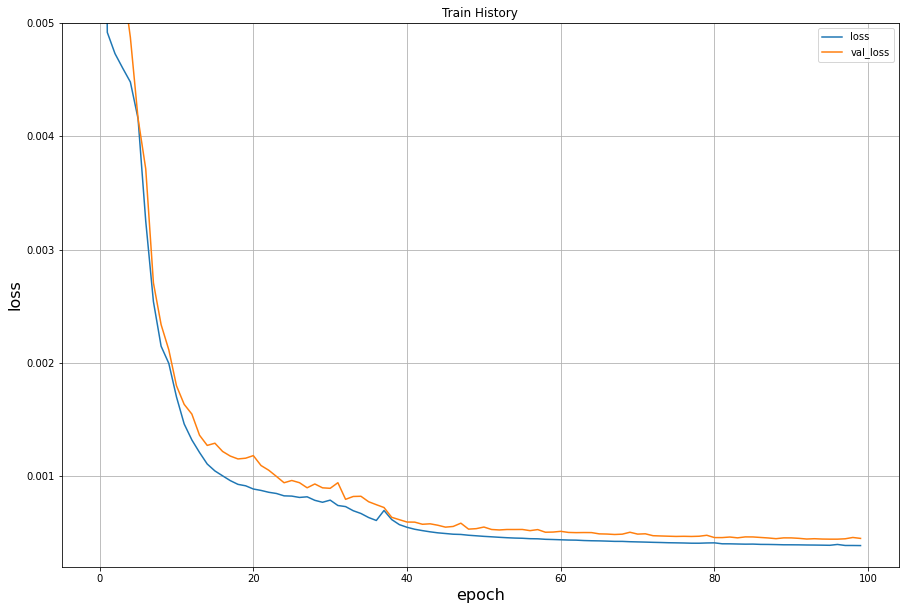

In [77]:

def plotLearningCurves( history):
    df = pd.DataFrame(history.history)
    df.plot(figsize=(15,10))  
    plt.legend(markerscale=1000)
    plt.grid(True) # 顯示網格
    plt.xlabel('epoch', fontsize = 16)  
    plt.ylabel('loss', fontsize = 16) 
    plt.title('Train History')
    plt.gca().set_ylim(0.0002, 0.005)   
    plt.show()
    
plotLearningCurves(history_sequence_autoencoder)

In [16]:
#儲存
model_AE.sequence_encoder.save('model_trained/sequence_encoder_100e.h5')
model_AE.sequence_bridge.save('model_trained/sequence_bridge_100e.h5')
model_AE.sequence_autoencoder.save('model_trained/sequence_autoencoder_100e.h5')

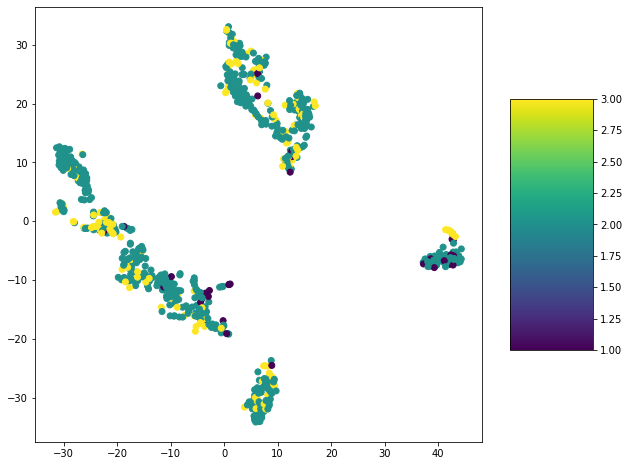

(207974, 3)
(800, 2)


In [49]:

###繪製TSNE
# get code
# encode = model_2.encode(test_data.images)
testX_encode = model_AE.sequence_encoder.predict(testX,batch_size=128)
# TSNE 2D visualization
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,random_state=38,perplexity=42)   #n_components >>嵌入空间的维度
X_embedded = tsne.fit_transform(testX_encode[:800])
# Y = np.argmax(testY, axis=0)   #要放score Y
# plot
plt.figure(figsize=(10, 8))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=testdata.Y.values[:800])
plt.colorbar(aspect=3)
plt.show()

print(testX_encode.shape)
print(X_embedded.shape)

# EN+LSTM

In [51]:
from tensorflow.keras.models import load_model
### 建模 EN-LSTM
start = time.time()


# load the model from file
sequence_autoencoder = load_model('/3T_HD/Neng/智慧機車_data/data_中山_bydriver/Best_10_drivers/MODEL_DATA_10_AllNormal_大於600_by_journey/model_3class_05s/model_trained/sequence_autoencoder_100e.h5')
encoder = Model(sequence_autoencoder.input,sequence_autoencoder.layers[-4].output)
encoder.summary()

#壓縮
trainX_encoded = encoder.predict(trainX,batch_size=128)  #
testX_encoded  = encoder.predict(testX,batch_size=128)

# 接上LSTM
inputs = Input(shape=(3,3))
lstm1 = LSTM(64, activation='relu',kernel_initializer='he_uniform',bias_regularizer=regularizers.l1_l2(10e-5),
             return_sequences=True)(inputs)
D1=Dropout(0.2)(lstm1)
lstm2 = LSTM(16, activation='relu',kernel_initializer='he_uniform', bias_regularizer=regularizers.l1_l2(10e-5),
             return_sequences=False)(D1)
D2=Dropout(0.2)(lstm2)
regression_layers= Dense(3, activation='softmax')(D2)

model_L_E = Model(inputs, regression_layers)
model_L_E.compile(loss='categorical_crossentropy', optimizer='adam')
model_L_E.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2) 
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history_L_E = model_L_E.fit(trainX_encoded, trainY, validation_split=0.1, 
                        epochs=100, batch_size=128, verbose=1,
                           callbacks=[early_stopping,tensorboard_callback])

# # 拿壓縮後的 testX丟進去預測
testX_pred_L=model_L_E.predict(testX_encoded)#預測



end = time.time()
print(start, end)
print("執行時間：%f 秒" % (end - start))



Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3, 6)]            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 3, 32)             4992      
_________________________________________________________________
lstm_11 (LSTM)               (None, 3, 16)             3136      
_________________________________________________________________
lstm_12 (LSTM)               (None, 3)                 240       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 3, 3)              0         
Total params: 8,368
Trainable params: 8,368
Non-trainable params: 0
_________________________________________________________________
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Sh

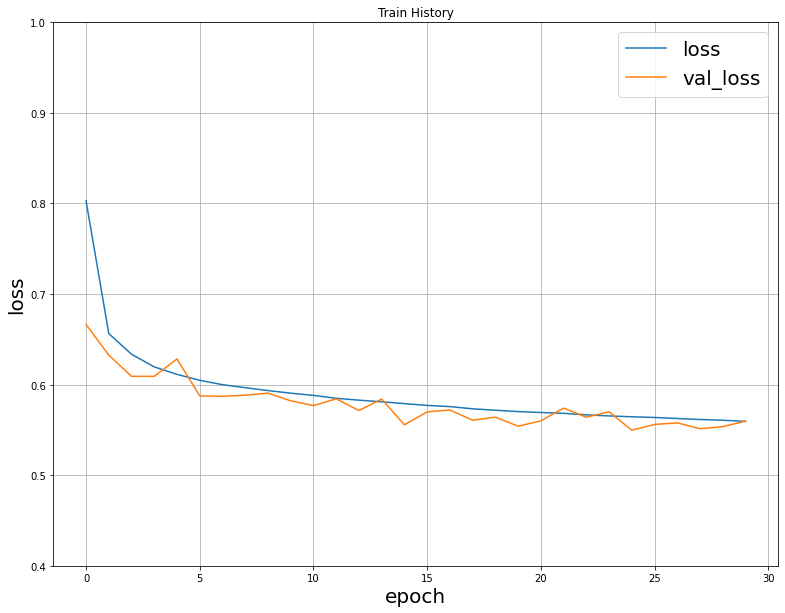

In [53]:
def plotLearningCurves(history):
    df = pd.DataFrame(history.history)
    df.plot(figsize=(13,10))  
    plt.legend(markerscale=1000, fontsize=20)
    plt.grid(True) # 顯示網格
    plt.xlabel('epoch', fontsize = 20)  
    plt.ylabel('loss', fontsize = 20) 
    plt.title('Train History')
    plt.gca().set_ylim(0.4, 1)   
    plt.show()
plotLearningCurves(history_L_E)

In [54]:
from sklearn.metrics import classification_report,confusion_matrix

y_pred=np.argmax(testX_pred_L, axis=1)
y_test=np.argmax(testY, axis=1)
cm = confusion_matrix(y_test, y_pred)

print(cm)
print(classification_report(y_test,y_pred, digits=4))

[[52696 11430    75]
 [13197 57053  7572]
 [  537 16032 49382]]
              precision    recall  f1-score   support

           0     0.7933    0.8208    0.8068     64201
           1     0.6751    0.7331    0.7029     77822
           2     0.8659    0.7488    0.8031     65951

    accuracy                         0.7651    207974
   macro avg     0.7781    0.7676    0.7709    207974
weighted avg     0.7721    0.7651    0.7667    207974



Normalized confusion matrix
[[0.82079718 0.17803461 0.00116821]
 [0.1695793  0.73312174 0.09729896]
 [0.00814241 0.24308957 0.74876802]]


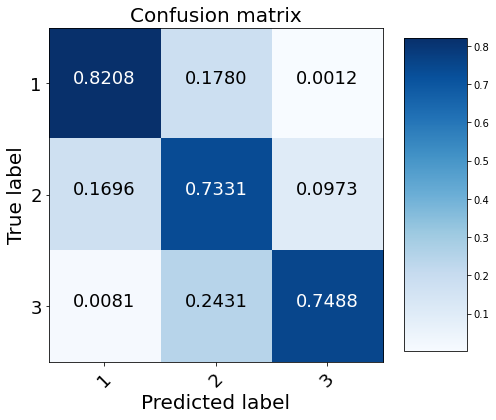

In [55]:

y_pred=np.argmax(testX_pred_L, axis=1)
y_test=np.argmax(testY, axis=1)
cm = confusion_matrix(y_test, y_pred)
class_names = ['1','2','3']
plot_confusion_matrix(cm, class_names)

Confusion matrix, without normalization
[[52696 11430    75]
 [13197 57053  7572]
 [  537 16032 49382]]


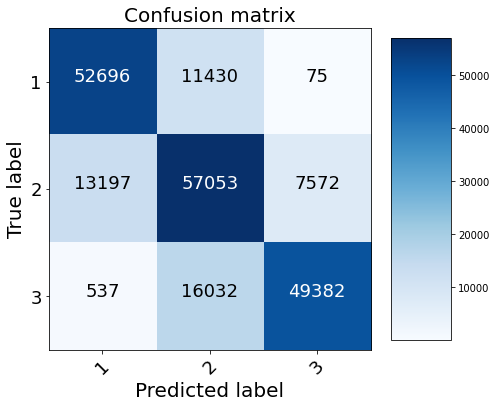

In [56]:
plot_confusion_matrix(cm, class_names, normalize=False)

# EN_GRU

In [74]:
from tensorflow.keras.models import load_model
### 建模 EN-LSTM
start = time.time()



# load the model from file
sequence_autoencoder = load_model('/3T_HD/Neng/智慧機車_data/data_中山_bydriver/Best_10_drivers/MODEL_DATA_10_AllNormal_大於600_by_journey/model_3class_05s/model_trained/sequence_autoencoder_100e.h5')
encoder = Model(sequence_autoencoder.input,sequence_autoencoder.layers[-4].output)

encoder.summary()

trainX_encoded = encoder.predict(trainX,batch_size=128)  #
testX_encoded  = encoder.predict(testX,batch_size=128)

inputs = Input(shape=(3,3))
lstm1 = GRU(64, activation='relu',kernel_initializer='he_uniform',bias_regularizer=regularizers.l1_l2(10e-5),
             return_sequences=True)(inputs)
D1=Dropout(0.2)(lstm1)
lstm2 = GRU(16, activation='relu',kernel_initializer='he_uniform', bias_regularizer=regularizers.l1_l2(10e-5),
             return_sequences=False)(D1)
D2=Dropout(0.2)(lstm2)
regression_layers= Dense(3, activation='softmax')(D2)

model_G_E = Model(inputs, regression_layers)
model_G_E.compile(loss='categorical_crossentropy', optimizer='adam')
model_G_E.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2) 
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history_G_E = model_G_E.fit(trainX_encoded, trainY, validation_split=0.1, 
                        epochs=100, batch_size=128, verbose=1,
                           callbacks=[early_stopping,tensorboard_callback])



testX_pred_G=model_G_E.predict(testX_encoded)#預測



end = time.time()
print(start, end)
print("執行時間：%f 秒" % (end - start))



Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3, 6)]            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 3, 32)             4992      
_________________________________________________________________
lstm_11 (LSTM)               (None, 3, 16)             3136      
_________________________________________________________________
lstm_12 (LSTM)               (None, 3)                 240       
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 3, 3)              0         
Total params: 8,368
Trainable params: 8,368
Non-trainable params: 0
_________________________________________________________________
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Sh

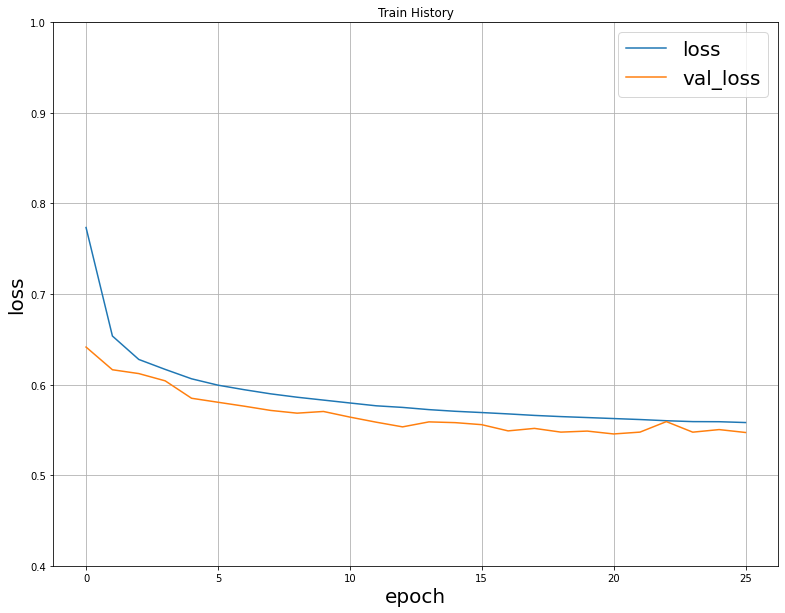

[[51272 12807   122]
 [11312 57515  8995]
 [  475 14581 50895]]
              precision    recall  f1-score   support

           0     0.8131    0.7986    0.8058     64201
           1     0.6774    0.7391    0.7069     77822
           2     0.8481    0.7717    0.8081     65951

    accuracy                         0.7678    207974
   macro avg     0.7795    0.7698    0.7736    207974
weighted avg     0.7734    0.7678    0.7695    207974

Normalized confusion matrix
[[0.79861684 0.19948287 0.00190028]
 [0.14535735 0.73905836 0.11558428]
 [0.00720232 0.22108838 0.7717093 ]]
Confusion matrix, without normalization
[[51272 12807   122]
 [11312 57515  8995]
 [  475 14581 50895]]


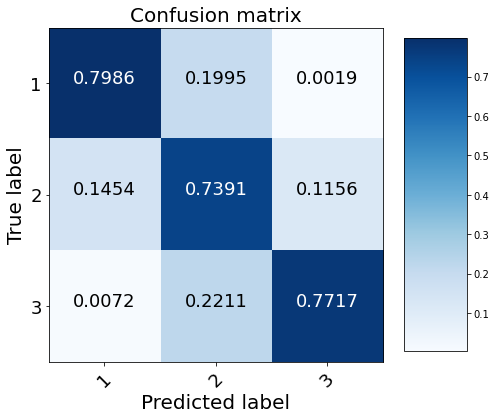

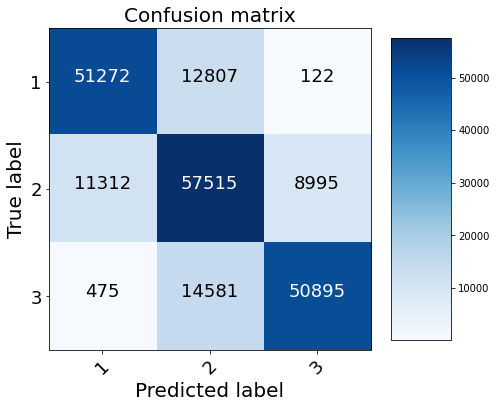

In [75]:
plotLearningCurves(history_G_E)
from sklearn.metrics import classification_report,confusion_matrix

y_pred=np.argmax(testX_pred_G, axis=1)
y_test=np.argmax(testY, axis=1)
cm = confusion_matrix(y_test, y_pred)

print(cm)
print(classification_report(y_test,y_pred, digits=4))

class_names = ['1','2','3']
plot_confusion_matrix(cm, class_names)
plot_confusion_matrix(cm, class_names, normalize=False)

# -------